In [2]:
import torch
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

模型逆向攻击，人工智能人脸识别系统逆向恢复人脸
在给出标签（人名）时，通常会给出浮点置信度，因此可将反转任务作为一个优化问题来进行攻击：在分类与目标相匹配的前提下，找到能使返回置信度最大化的输入。

首先读出训练测试集

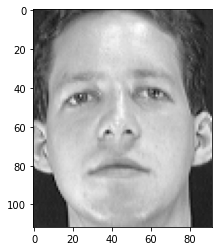

In [3]:
# 定义文件夹路径
folder_path = 'faces'
# 获取文件夹中的所有文件
file_list = os.listdir(folder_path)

#创建一个人脸标签（classes）的列表和两个函数，
# 一个用于将标签名称转换为索引（c_to_i），另一个用于将索引转换为标签名称（i_to_c）
def get_label():
    face_label = [0]*40
    for i in range (40):
        name = "s" + str(i+1)
        face_label[i] = name
    return face_label
classes = get_label()
#Lambda函数，它接受一个标签名称作为参数x
#然后使用index方法在classes列表中查找该标签的索引
#实现了从标签名称到索引的转换。
c_to_i = lambda x: classes.index(x)
#实现了从索引到标签名称的转换
i_to_c = lambda x: classes(x)


def show_img(im):
    plt.imshow(im.reshape(112, 92) / 2 + .5, cmap='gray')
    plt.show()


#图像预处理，先将图像转换为PyTorch张量，然后进行标准化
MEAN = 0.1307
STD = 0.3081
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MEAN), (STD)),
])

transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量
])

train = test = 0
train_x, train_y = ([0]) * 360, ([0])*360
test_x, test_y = ([0]) * 40, ([0])*40


#加载人脸图像数据并将其转换为张量
for c in classes:
    for faces in os.listdir('faces/train/'+c):
         # convert('L') 是把图像转换成灰度图，0表示黑，255表示白，其他数字表示不同的灰度。
         img = np.array(Image.open('faces/train/'+c+'/'+faces).convert('L'))
         #将灰度图像矩阵压平（flatten），将二维图像数据转换为一维数组
         #将图像数据展平为一维向量是常见的数据预处理步骤。
         # 结果存储在训练集 train_x 和测试集 test_x 中
         train_x[train] = (img).flatten()
         train_y[train] = (c_to_i(c))
         train +=1

    for faces in os.listdir('./faces/test/'+c):
        img = np.array(Image.open('./faces/test/'+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

#将所有展平后的图像堆叠成一个多维数组，并将标签转换为NumPy数组
#np.stack(arrays, axis = 0)数组的序列，堆叠的维度
train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([y.flatten() for y in test_x])
train_y = np.array(train_y, dtype=np.int64)
test_y = np.array(test_y, dtype = np.int64)

#type(train_x[0])
show_img(train_x[0])

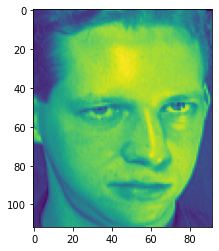

92 112


In [8]:
img = Image.open('faces/test/s1/1.pgm')
weight, high = img.size
plt.imshow(img)
plt.show()

print(weight, high)

In [45]:
pip install opacus

     |████████████████████████████████| 224 kB 343 kB/s eta 0:00:01
     |████████████████████████████████| 143.1 MB 359 kB/s eta 0:00:01     |███▎                            | 14.6 MB 864 kB/s eta 0:02:29     |████████▉                       | 39.5 MB 305 kB/s eta 0:05:40
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
#使用Opacus库实现差分隐私的PyTorch模型训练
from opacus import PrivacyEngine
from torch.utils.data import TensorDataset,DataLoader

class FaceModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(FaceModel, self).__init__()

        self.linear1 = torch.nn.Linear(D_in, D_out)

    def forward(self, x):
        return self.linear1(x)
    
# 创建了一个FaceModel的实例，传入了输入特征数和输出类别数。
model = FaceModel(len(train_x[0]), len(classes))
#损失函数
criterion = torch.nn.CrossEntropyLoss()
#优化器
optimizer = torch.optim.SGD(model.parameters(), lr=3e-1)

Train_DS = TensorDataset(torch.tensor(train_x), torch.tensor(train_y))
Train_DL = DataLoader(Train_DS, batch_size=360)
#创建了一个差分隐私引擎的实例，用于为模型添加差分隐私保护。
privacy_engine = PrivacyEngine()
#使用差分隐私引擎的make_private方法，将模型、优化器和数据加载器包装在一起，以添加差分隐私保护。
# 在此过程中，你可以指定差分隐私的参数，如噪声乘子（noise_multiplier）和梯度裁剪的最大范数（max_grad_norm）
model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=Train_DL,
    noise_multiplier=1.1,
    max_grad_norm=1.0,
)

/Users/gaoyishu/opt/anaconda3/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [48]:
type(model)

opacus.grad_sample.grad_sample_module.GradSampleModule

In [5]:
#训练300轮
steps = 300
for i in tqdm(range(steps)):
    for train_X, train_Y in data_loader:
        train_X = train_X.float()
        optimizer.zero_grad()
        #前向传播，将输入数据传递给模型并生成预测结果。
        y_hat = model(train_X)
        #计算损失
        loss = criterion(y_hat, torch.LongTensor(train_Y))
        #反向传播
        loss.backward()
        optimizer.step()


  0%|          | 0/300 [00:00<?, ?it/s]/Users/gaoyishu/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 300/300 [03:24<00:00,  1.47it/s]


In [8]:
#使用 Opacus 库的隐私工具来计算隐私泄露的值（epsilon）和最佳 alpha 值
epsilon, best_alpha = privacy_engine.accountant.get_privacy_spent(delta=1e-5)
print(epsilon, best_alpha)

AttributeError: 'PRVAccountant' object has no attribute 'get_privacy_spent'

In [15]:
model, optimizer, data_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=Train_DL,
    noise_multiplier=1.1,
    max_grad_norm=1.0,
)
#测试模型的性能
for test_X, test_Y in data_loader:
    optimizer.zero_grad()
    test_X = test_X.float()     
    y_hat = model(test_X)
    _, y_predict = torch.max(y_hat, 1)
    print((y_predict == test_Y).sum())

tensor(334)


/Users/gaoyishu/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


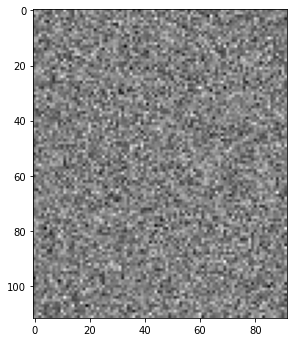

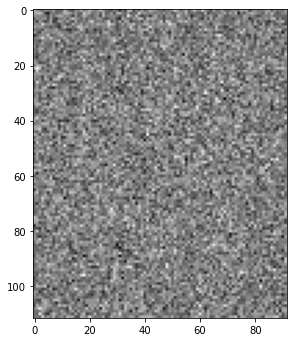

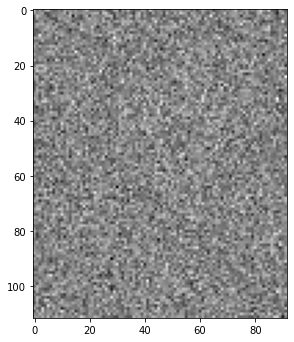

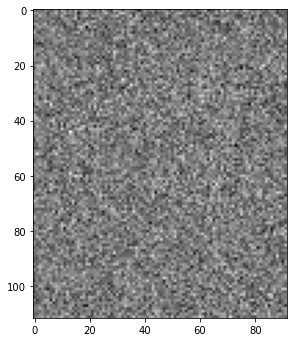

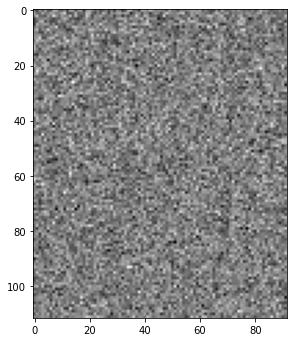

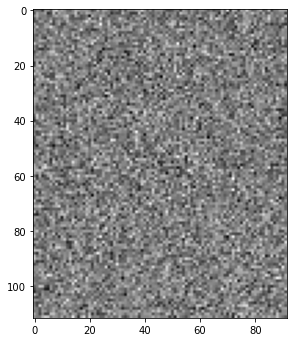

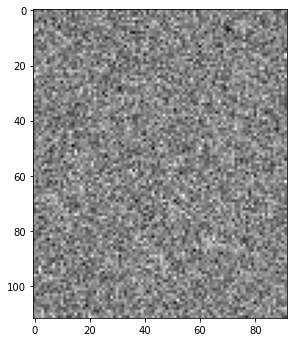

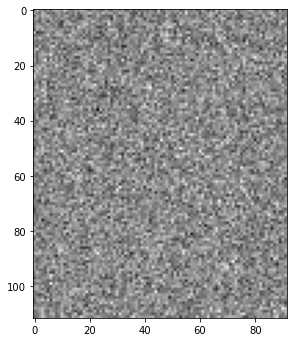

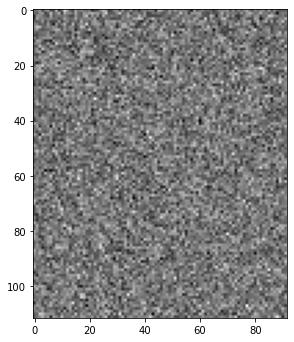

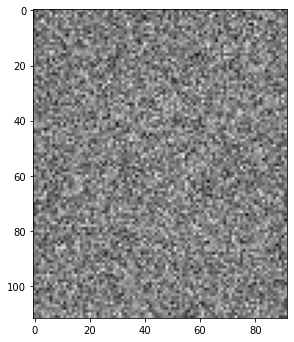

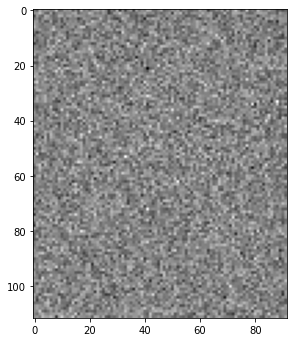

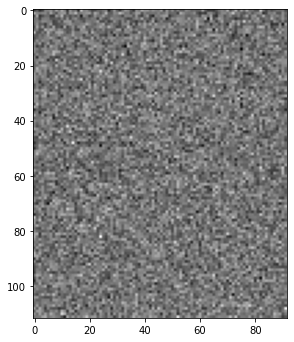

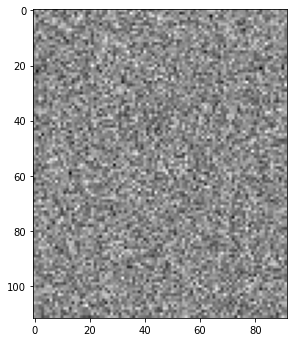

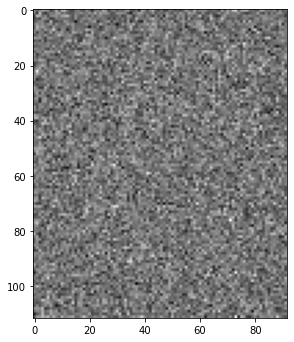

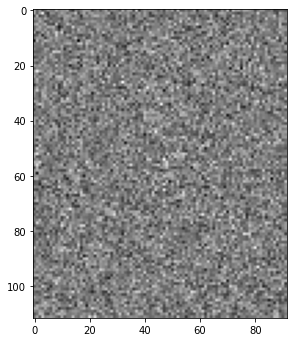

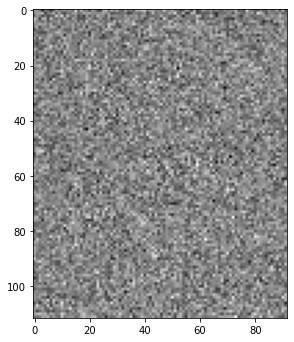

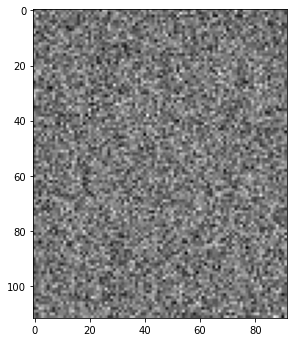

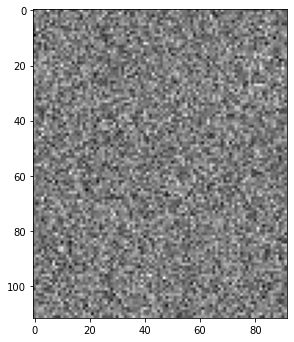

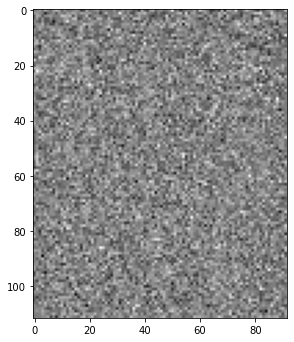

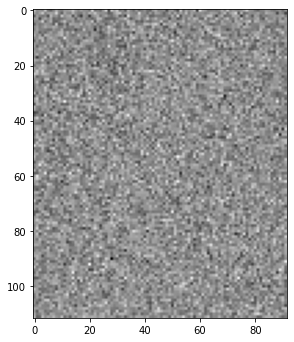

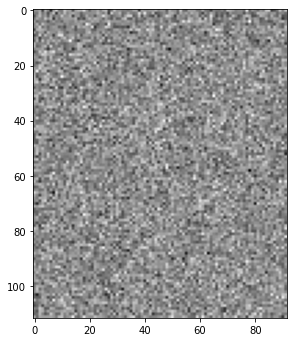

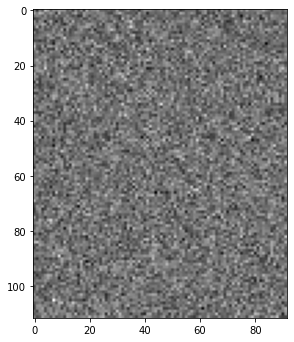

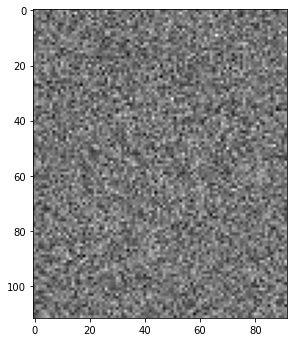

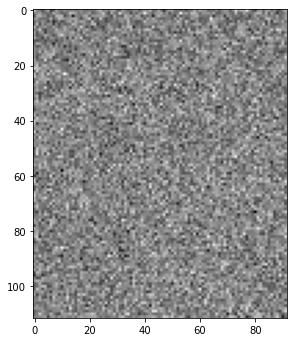

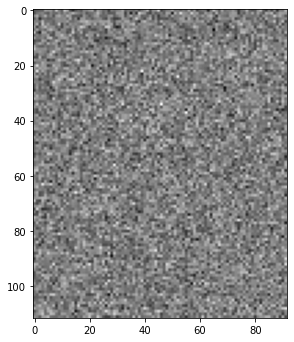

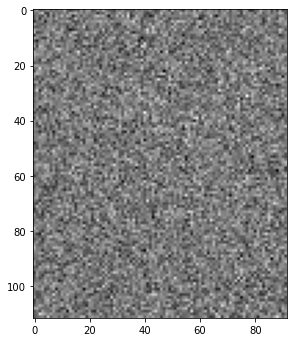

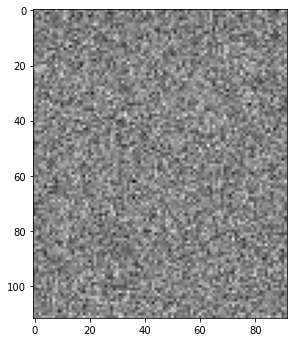

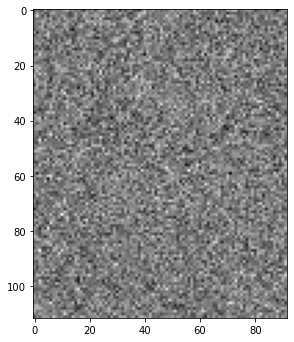

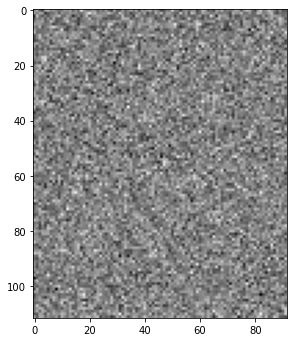

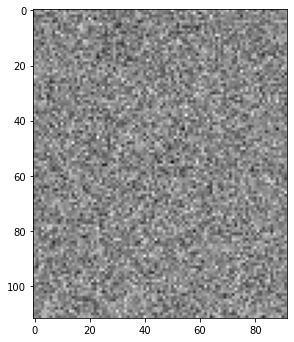

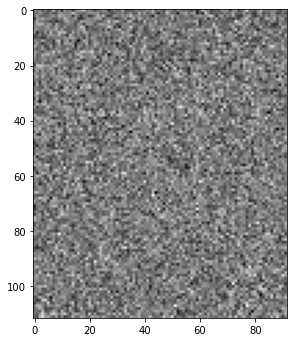

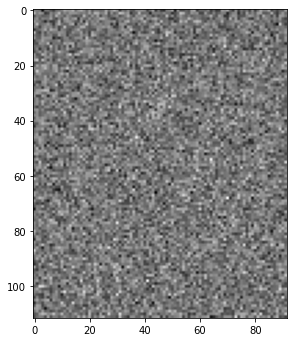

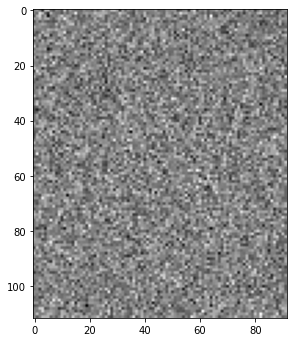

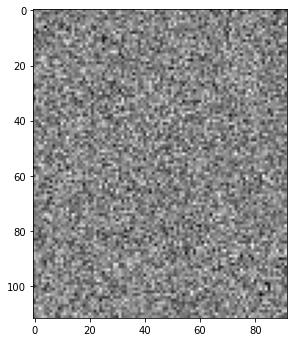

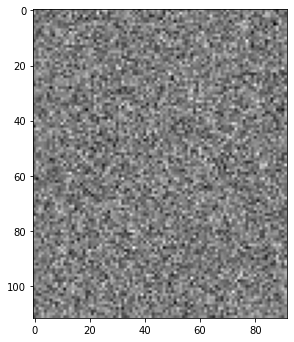

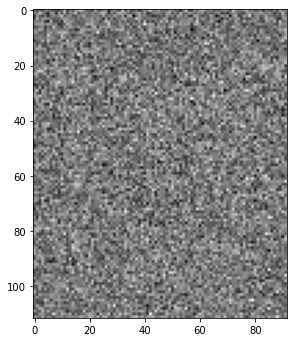

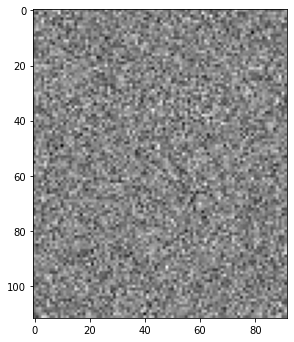

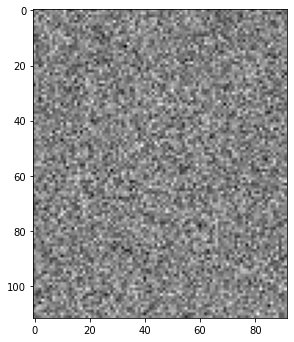

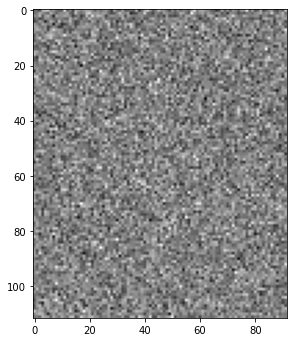

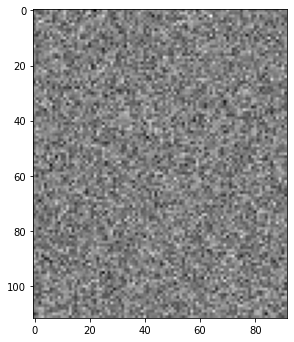

1

In [27]:
from scipy.ndimage import gaussian_filter, convolve
# 高斯滤波 是一种线性平滑滤波，可以去除高斯噪声，其效果是降低图像灰度的尖锐变化，即让图像变模糊

#字符串pred
pred = ''

#逆向函数，修改img，使其逼近目标标签c的预测结果
# 传入的参数中，model是训练的人脸识别模型，img初始值是全0的与图像大小相同的数组，c_to_i(c)是目标标签
# best_loss 是目标要最小化的loss值，初始是无穷大， best_x 是当best_loss时的样本img，i是迭代轮数
def invert(model, img, lr,  c, best_loss, best_x, optimizer):
    #将img转换为(1, 10304)能够输入到网络中的形状
    #.view(1, -1) 第一个维度为1，第二个维度根据元素数量自动计算。这里为10304，因为92*112个像素
    img = torch.Tensor(img).view(1, -1).float()
    #组成图像-标签数据集
    Train_DS = TensorDataset(img, torch.tensor([c]))
    Train_DL = DataLoader(Train_DS, batch_size = 1)
    model.train()
    # model, optimizer, data_loader = privacy_engine.make_private(
        # module = model,
        # optimizer=optimizer,
        # data_loader=Train_DL,
    #     noise_multiplier=1.1,
    #     max_grad_norm=1.0,
    # )
    if not img.requires_grad:
        img.requires_grad = True
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()
    img = torch.clamp(img - lr * img.grad, 0, 255)
    #如果当前损失小于最佳损失并且迭代次数 i 大于 10，则更新最佳损失和最佳图像 best_loss 和 best_x
    if loss.detach().numpy() < best_loss and i>10:
    #为了增加模型的隐私和鲁棒性，对图像的每个像素值使用正态分布添加了一些随机噪声。
        np_a = np.array([np.clip(x + np.random.normal(0.2, 0.2),0,255) for x in img.detach().numpy()])
    
    #对输入图像进行一些噪声扰动
    filt = np.array([
        [0,-1,0],
        [-1,5,-1],
        [0,-1,0]
    ])
    #np.random.normal(2, 2) 从均值为2，标准差为2的正态分布中随机采样一个值
    # np.clip 与 torch.clamp 效果类似，限定 x + np.random.normal(2, 2)的区间范围
    # 因此该相当于对 img 的每个元素添加一个从均值为2，标准差为2的正态分布中随机采样的值
    np_a = np.array([np.clip(x + np.random.normal(0.2, 0.2),0,255) for x in img.detach().numpy()])
    best_x = np_a

    return best_loss, best_x, np_a.reshape(1, -1)


#通过迭代修改图像，使其在经过人脸识别模型时，模型的预测结果最接近目标标签 c。
for c in classes:
    #float('inf')表示正无穷 初始图像best_x为空，损失为正无穷
    best_x, best_loss = '', float('inf')
    #一个全0图像img，大小与训练数据中的图像一样
    img = np.zeros_like(train_x[0])

    for i in range(100):
        best_loss, best_x, img = invert(model, img, .01, c_to_i(c), best_loss, best_x, optimizer)

    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(best_x.reshape(112, 92), cmap='gray')
    plt.show()





1

In [28]:
model = FaceModel(len(train_x[0]), len(classes))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 3e-1)

steps = 70
for i in tqdm(range(step)):
    optimizer.zero_grad()
    y_hat = model(torch.Tensor(train_x))
    loss = criterion(y_hat, torch.LongTensor(train_y))
    loss.backward()
    optimizer.step()
#评估模型，不进行梯度计算和参数更新
model.eval()
def invert_primary(model, img, lr, c, best_loss, best_x, optimizer):
    #将img转换为(1, 10304)能够输入到网络中的形状
    #.view(1, -1) 第一个维度为1，第二个维度根据元素数量自动计算。这里为10304，因为92*112个像素
    img = torch.Tensor(img).view(1, -1).float()
    if not img.requires_grad:
        img.requires_grad = True
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()
    img = torch.clamp(img - lr*img.grad, 0, 255)
    #如果当前损失小于最佳损失并且迭代次数 i 大于 10，则更新最佳损失和最佳图像 best_loss 和 best_x
    if loss.detach().numpy() < best_loss and i>10:
    # #为了增加模型的隐私和鲁棒性，对图像的每个像素值使用正态分布添加了一些随机噪声。
    #     np_a = np.array([np.clip(x + np.random.normal(0.2, 0.2),0,255) for x in img.detach().numpy()])
        best_loss = loss.detach().numpy()
        best_x = img.detach().numpy()
    #定义处理图像任务的滤波器flit
    flit = np.array([
        [0,-1,0],
        [-1,5,-1],
        [0,-1,0]
        ])
    np_a = np.array([np.clip(x + np.random.normal(0.2, 0.2),0,255) for x in img.detach().numpy()])
    return best_loss, best_x, np_a.reshape(1, -1)

#逆向并展示逆向后的图像
for c in classes:
    #float('inf')表示正无穷 初始图像best_x为空，损失为正无穷
    best_x, best_loss = '', float('inf')
    #一个全0图像img，大小与训练数据中的图像一样
    img = np.zeros_like(train_x[0])

    for i in range(100):
        best_loss, best_x, img = invert_primary(model, img, .01, c_to_i(c), best_loss, best_x, optimizer)
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(best_x.reshape(112, 92), cmap='gray')
    plt.show()


TypeError: 'method' object is not iterable